# Secondary Loan Market Simulation Notebook


### The Loan Class

In [29]:
import numpy as np
import uuid
import matplotlib.pyplot as plt
import time

In [30]:
class Loan:
    """
    Represents a loan in the simulation.
    
    Attributes:
        id (str): Unique identifier for the loan.
        maturity (int): Number of cycles until the loan matures.
        current_cycle (int): The current cycle of the simulation.
        starting_cycle (int): The cycle when the loan was initiated.
        ending_cycle (int): The cycle when the loan will end.
        time_to_maturity (int): Number of cycles until the loan matures.
        pd (float): Probability of default for the loan.
        size (float): Size of the loan.
        interest_rate (float): Interest rate of the loan.
        fair_value (float): Fair value of the loan.
        market_price (float): Market price of the loan.
        current_owner (str): The current owner of the loan.
        maturity_bool (bool): Indicates if the loan has matured.
        fair_value_history (list): History of the loan's fair values.
        market_price_history (list): History of the loan's market prices.
        ownership_history (list): History of the loan's ownership.
    """
    
    __slots__ = ['id', 'maturity', 'current_cycle', 'starting_cycle', 'ending_cycle', 'time_to_maturity', 'pd', 'size', 'interest_rate', 'fair_value', 'market_price', 'current_owner', 'maturity_bool', 'fair_value_history', 'market_price_history', 'ownership_history'] 
    
    def __init__(self, current_cycle=0, current_owner="no owner"):
        """
        Initializes the Loan with random values for maturity, pd, size, interest rate, and fair value.
        Sets the starting cycle, calculates the ending cycle and time to maturity based on maturity.
        Initializes histories and sets the current owner.
        """
        
        self.id = str(uuid.uuid4())
        self.maturity = np.random.randint(3, 8)
        self.current_cycle = current_cycle
        self.starting_cycle = self.current_cycle
        self.ending_cycle = self.starting_cycle + self.maturity
        self.time_to_maturity = self.ending_cycle - self.current_cycle  # Consider calculating this on the fly
        self.pd = np.random.beta(1, 50)
        self.size = np.random.uniform(500_000, 5_000_000)
        self.interest_rate = self.generate_interest_rate()
        self.fair_value = self.calculate_price()
        self.market_price = self.fair_value
        self.current_owner = current_owner
        self.maturity_bool = False
        
        # tracking attributes
        self.fair_value_history = []
        self.market_price_history = []
        self.ownership_history = [current_owner]

    def generate_interest_rate(self):
        """
        Generates a random interest rate based on some factors and noise.
        The interest rate is influenced by the loan's probability of default.
        """
        
        base_level_noise = np.random.normal(0.02, 0.005)
        correlation_factor = 0.8
        influence_factor = np.random.uniform(0.05, 0.15)
        correlated_component = correlation_factor * self.pd * influence_factor
        return base_level_noise + correlated_component

    def calculate_price(self):
        """
        Calculates the price of the loan based on its attributes.
        The price is influenced by the probability of default, interest rate, and size.
        """
        
        pd_effect = -7 * self.pd if self.pd <= 0.2 else -14 * self.pd  
        ir_effect = 5 * self.interest_rate
        size_effect = -0.0000002 * self.size
        return 100 + pd_effect + ir_effect + size_effect
    
    @staticmethod
    def generate():
        return Loan()
    
    def update_owner(self, new_owner):
        self.current_owner = new_owner
        self.ownership_history.append(new_owner)
        
    
    def update(self, current_cycle, new_owner = None, new_market_price=None):
        """
        Updates the loan's attributes for a new cycle.
        If the loan has matured, checks for default and adjusts fair value and market price accordingly.
        Records the changes in the histories.
        
        Args:
        current_cycle (int): The new current cycle.
        new_owner (str, optional): The new owner of the loan, if it has changed.
        new_market_price (float, optional): The new market price of the loan, if it has changed.
        """

        if current_cycle > self.ending_cycle:
            return
        
        if new_owner:
            self.update_owner(new_owner)
        
        self.current_cycle = current_cycle
        self.time_to_maturity = self.ending_cycle - self.current_cycle
        self.fair_value = self.calculate_price()
        
        if new_market_price:
            self.market_price = new_market_price
        self.market_price_history.append(self.market_price)
        
        # Loan maturity logic
        if current_cycle == self.ending_cycle:
            self.maturity_bool = True
            default_outcome = np.random.rand() < self.pd
            if default_outcome:
                self.fair_value = np.random.normal(10, 2)
                self.market_price = self.fair_value  # Set to liquidation value
            else:
                self.fair_value = 100  # Set to par value
                self.market_price = 100  # Set to par value
        self.fair_value_history.append(self.fair_value)
    
    

In [89]:
class LoanInvestor:
    def __init__(self, trader=None, capital=None):
        self.id = 'I'+str(uuid.uuid4())
        self.capital = capital if capital else self.generate_initial_capital()
        self.capital_history = []
        self.target_score = np.abs(np.random.normal(1.1, 0.2))
        self.loan_fair_values = []
        self.portfolio_values = []
        self.portfolio = []
        self.matured_loans = []
        self.current_score = 0
        self.trader = trader
        self.interest_received = []
        
        # adding in trading logic
        self.loans_for_sale = []
    
    def generate_initial_capital(self):
        random_capital = np.round((np.random.pareto(2, 1) + 1)*50*1000000, 0)[0]
        return random_capital
    
    def initialize_portfolio(self, available_loans, capital_threshold=0.9):
        
        """
        Initializes the investor's portfolio with available loans.
        :param available_loans: List of available loans already prepared by the loanMarket class.
        :param capital_threshold: Maximum proportion of capital to be invested.
        """
        
        np.random.shuffle(available_loans)
        total_investment = 0
        for loan in available_loans:
            purchase_value = (loan.market_price/100) * loan.size
            if total_investment + purchase_value <= self.capital*capital_threshold:
                total_investment += purchase_value
                loan.update_owner(self.id)
                self.portfolio.append(loan)
            else:
                break
        
        self.capital -= total_investment
        self.calculate_current_score()
        self.loan_fair_values.append(np.sum([(loan.fair_value * (loan.size/100)) for loan in self.portfolio]))
        self.portfolio_values.append(self.loan_fair_values[-1] + self.capital)
        self.capital_history.append(self.capital)
        
    def calculate_value(self):
        self.loan_fair_values.append(np.sum([((loan.fair_value/100) * loan.size) for loan in self.portfolio]))
        self.portfolio_values.append(self.loan_fair_values[-1] + self.capital)
        self.capital_history.append(self.capital)
        
    def calculate_current_score(self):
        weighted_interest = sum([loan.interest_rate * loan.size for loan in self.portfolio])
        weighted_pd = sum([loan.pd * loan.size for loan in self.portfolio])
        total_size = sum([loan.size for loan in self.portfolio])
        self.current_score = (weighted_interest / total_size) / (weighted_pd / total_size) if weighted_interest > 0 else 0
    
    def receive_interest(self, float_interest = 0):
        '''
        This is the procedure every cycle for the investor to receive interest on their loans. 
        :param float_interest: The floating base rate for interest (think SOFR)
        '''
        total_interest = 0
        for loan in self.portfolio:
            if loan.maturity_bool==True:
                self.capital += (loan.fair_value/100) * loan.size
                self.matured_loans.append(loan)
                self.portfolio.remove(loan)
            else:
                total_interest += loan.size * (loan.interest_rate + float_interest)
                
        self.capital += total_interest
        self.interest_received.append(total_interest)
        
            
    def get_loan_to_sell(self, num_select = 3):
        # process to find the top loans that contribute to PD in the wrong direction in terms of absolute value
        # returns the top loan to sell which would be passed to their trader
        
        # start by sorting the portfolio by PD
        sorted_portfolio = sorted(self.portfolio, key=lambda x: x.pd/x.interest_rate, reverse=True)
        
        # finding out what the wrong direction is by comparing current pd to target pd
        wrong_direction = self.current_score > self.target_score
        
        # if the current score is less than the target score, then the wrong direction is positive, meaning we should sell the highest score loans
        # if the current score is greater than the target score, then the wrong direction is negative, meaning we should sell the lowest score loans
        if wrong_direction:
            top_wrong_direction = sorted_portfolio[:num_select]
        else:
            top_wrong_direction = sorted_portfolio[-num_select:]
            
            
        loan_to_sell = np.random.choice(top_wrong_direction)
        self.loans_for_sale.append(loan_to_sell)
        
        return loan_to_sell
        
    def get_bid_price(self, loan):
        # takes a loan as an input and returns a bid price for the investor
        # breaks if the investor can't purchase the loan
          
        return
        
    def update(self, float_interest = 0):
        self.receive_interest(float_interest)
        self.calculate_value()
        self.calculate_current_score()

In [93]:
# testing the get loans to sell method of the investor
investor = LoanInvestor()
investor.initialize_portfolio([Loan() for _ in range(10)])

investor.get_loan_to_sell()

investor.loans_for_sale

In [39]:
class Trader:
    def __init__(self, max_investors, broker_fee = 0.15, partner_fee = 0.25):
        self.id = 'T'+str(uuid.uuid4())
        self.partner_trader = None
        self.broker_fee = broker_fee # fee for trading through the broker in bps
        self.friction_fee_partner = partner_fee # frictional fee for trading through the partner trader in bps
        self.max_investors = max_investors
        self.max_investors_reached = False
        self.loans_for_sale = []
        self.investors = []
    
    def add_investor(self, investors):
        for investor in investors:
            if investor.trader == None and len(self.investors) < self.max_investors:
                self.investors.append(investor)
                investor.trader = self
            else:
                self.max_investors_reached = True
                pass
            
    def initialize_book(self, available_loans):
        self.loans_for_sale.append(available_loans)
        for loan in available_loans:
            loan.update_owner(self.id)
    
    def run_auction(self):
        return

In [48]:
class loanMarket:
    def __init__(self, num_loans, num_investors, num_traders):
        
        self.cycle = 0
        self.num_loans = num_loans
        self.num_investors = num_investors
        self.num_traders = num_traders
        
        # creating the universe of loans
        self.loans = [Loan() for _ in range(self.num_loans)]
        
        # creating the universe of investors
        self.investors = [LoanInvestor() for _ in range(self.num_investors)]
        
        # creating the universe of traders
        self.traders = [Trader(max_investors = self.num_investors//self.num_traders) for _ in range(self.num_traders)]
        
    
    def initialize(self):
        
        for investor in self.investors:
            # regenerating list of available loans
            available_loans = [loan for loan in self.loans if loan.current_owner == "no owner"]
            investor.initialize_portfolio(available_loans)
        
        # Assign unsold loans to traders
        unsold_loans = [loan for loan in self.loans if loan.current_owner == "no owner"]
        unsold_loans_count = len(unsold_loans)
        loans_per_trader = unsold_loans_count // self.num_traders

        for trader_ in self.traders:
            trader_loans = unsold_loans[:loans_per_trader]
            unsold_loans = unsold_loans[loans_per_trader:]  # Update the unsold_loans list
            trader_.initialize_book(trader_loans)
            
            # Assign investors to the trader if they haven't reached their maximum
            if not trader_.max_investors_reached:
                trader_.add_investor(self.investors)
        
        # If there are any leftover loans, assign them randomly to the traders
        for loan in unsold_loans:
            trader = np.random.choice(self.traders)
            loan.update_owner(trader.id)
            trader.loans_for_sale.append(loan)

        # Assign any unassigned investors to traders randomly
        unassigned_investors = [investor for investor in self.investors if investor.trader is None]
        for investor in unassigned_investors:
            trader = np.random.choice(self.traders)
            trader.investors.append(investor)
            investor.trader = trader
            
        # Assign the partner trader to each trader
        for trader in self.traders:
            partner_trader = np.random.choice([t for t in self.traders if t != trader], replace=False)
            trader.partner_trader = partner_trader
            
    def update(self):
        for loan in self.loans:
            # loans are updated independent of investors
            loan.update(self.cycle+1)
        for investor in self.investors:
            # investors are updated based on the loans they hold
            investor.update()
        
        self.cycle += 1
        
    def get_average_portfolio_values(self):
        # Calculate the average portfolio value at the end of each cycle
        avg_portfolio_values = []
        for cycle in range(self.cycle):
            cycle_values = [investor.portfolio_values[cycle] for investor in self.investors if investor.portfolio_values]
            avg_value = sum(cycle_values) / len(cycle_values) if cycle_values else 0
            avg_portfolio_values.append(avg_value)
        return avg_portfolio_values
      

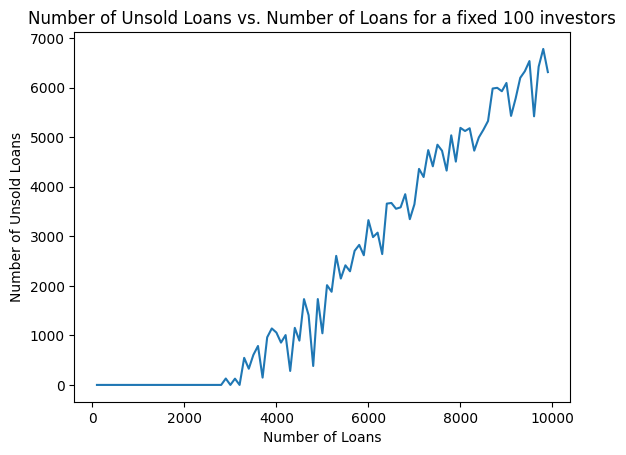

In [94]:
def get_unsold_loans(num_loans, num_investors):
    loans = [Loan() for _ in range(num_loans)]
    investors = [LoanInvestor() for _ in range(num_investors)]

    for investor in investors:
        # regenerating list of available loans
        available_loans = [loan for loan in loans if loan.current_owner == "no owner"]
        investor.generate_initial_capital()
        investor.initialize_portfolio(available_loans)

    unsold_loan_num = len([loan for loan in loans if loan.current_owner == "no owner"])

    return unsold_loan_num


# generating a plot that shows how unsold loans scale with the number of loans versus investors
unsold_loans = [get_unsold_loans(num_loans, 100) for num_loans in range(100, 10000, 100)]
plt.plot(range(100, 10000, 100), unsold_loans)
plt.xlabel("Number of Loans")
plt.ylabel("Number of Unsold Loans")
plt.title("Number of Unsold Loans vs. Number of Loans for a fixed 100 investors")
plt.show()

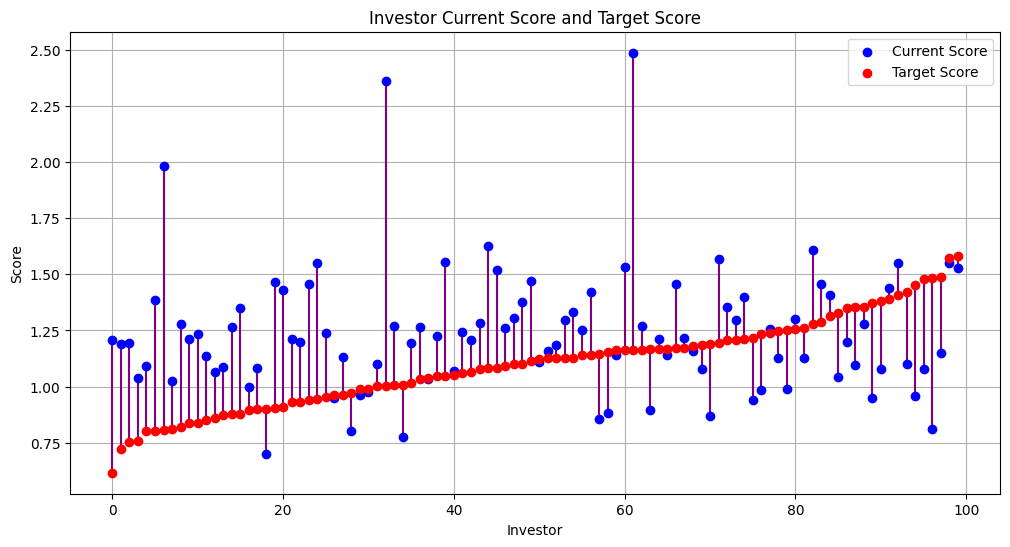

In [49]:
# plotting out the target vs current score for all the investors in the loan market

market = loanMarket(num_loans=10000, num_investors=100, num_traders=10)
market.initialize()

# Sorting the scores for a more organized visualization
current_scores = np.array([investor.current_score for investor in market.investors])
target_scores= np.array([investor.target_score for investor in market.investors])

# Sorting the scores for a more organized visualization
indices = np.argsort(target_scores)
current_scores_sorted = current_scores[indices]
target_scores_sorted = target_scores[indices]

# Creating a scatter plot with connected lines
plt.figure(figsize=(12, 6))
for i in range(market.num_investors):
    plt.plot([i, i], [current_scores_sorted[i], target_scores_sorted[i]], color='purple')  # lines
plt.scatter(range(market.num_investors), current_scores_sorted, color='blue', label='Current Score', zorder=5)
plt.scatter(range(market.num_investors), target_scores_sorted, color='red', label='Target Score', zorder=5)

plt.ylabel("Score")
plt.xlabel("Investor")
plt.title("Investor Current Score and Target Score")
plt.legend()
plt.grid(True)
plt.show()

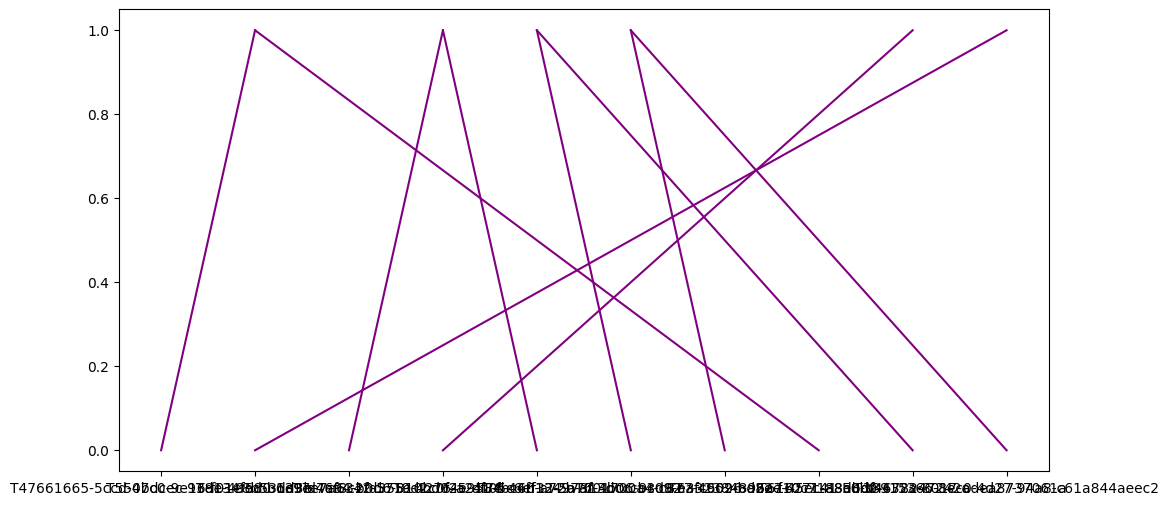

In [63]:
# creating a plot showing the connection between every trader and partner trader
plt.figure(figsize=(12, 6))
for trader in market.traders:
    plt.plot([trader.id, trader.partner_trader.id], [0, 1], color='purple')    

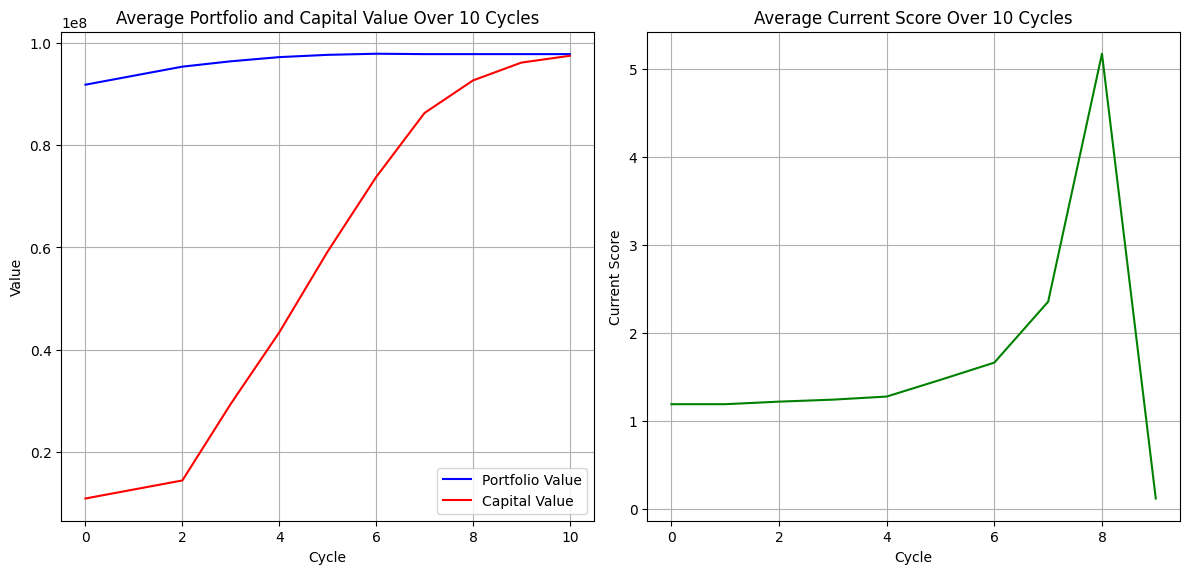

In [65]:
# creating a plot that shows the average portfolio, capital values, and current score over 10 cycles for every investor in the loan market
market = loanMarket(num_loans=10000, num_investors=100, num_traders=10)
market.initialize()

# Initialize the market
market = loanMarket(num_loans=10000, num_investors=100, num_traders=10)
market.initialize()

avg_current_scores = []
portfolio_values = []  
capital_values = []

# Update the market and gather data
for cycle in range(10):
    market.update()
    avg_current_scores.append(np.mean([investor.current_score for investor in market.investors]))

for investor in market.investors:
    portfolio_values.append(investor.portfolio_values)
    capital_values.append(investor.capital_history)
    
# Taking the per cycle average of portfolio and capital
avg_portfolio_values = np.mean(portfolio_values, axis=0)
avg_capital_values = np.mean(capital_values, axis=0)

# Plotting the average portfolio, capital and current score over 10 cycles using subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plotting both portfolio and capital values on the same subplot
axs[0].plot(range(11), avg_portfolio_values, label='Portfolio Value', color='blue')
axs[0].plot(range(11), avg_capital_values, label='Capital Value', color='red')
axs[0].set_title("Average Portfolio and Capital Value Over 10 Cycles")
axs[0].set_ylabel("Value")
axs[0].set_xlabel("Cycle")
axs[0].legend()
axs[0].grid(True)

# Plotting the current score on a separate subplot
axs[1].plot(range(10), avg_current_scores, color='green')
axs[1].set_title("Average Current Score Over 10 Cycles")
axs[1].set_ylabel("Current Score")
axs[1].set_xlabel("Cycle")
axs[1].grid(True)

plt.tight_layout()
plt.show()